In [1]:
%matplotlib inline

In [2]:
import os
from astropy.table import Table 

def load_sdss_colors_sample_value_added():
    """
    """
    dirname = "/Users/aphearin/work/sdss/umachine_colors_sdss_catalog"
    basename = "dr10_mgs_colors_value_added.hdf5"
    fname = os.path.join(dirname, basename)

    return Table.read(fname, path='data')
sdss = load_sdss_colors_sample_value_added()
sdss = sdss[sdss['rmag'] > -900]
sdss = sdss[sdss['sdss_petrosian_gr'] > -1]
sdss = sdss[sdss['sdss_petrosian_gr'] < 2]
sdss = sdss[sdss['sdss_petrosian_ri'] > -1]
sdss = sdss[sdss['sdss_petrosian_ri'] < 1.5]
print(sdss.keys())

['ra', 'dec', 'z', 'sm', 'ssfr', 'nd', 'rmag', 'sdss_petrosian_gr', 'sdss_petrosian_ri', 'size_kpc', 'dr7_photoobj_id', 'ssfr_percentile_fixed_sm']


## Develop power law fit to the $M_{\ast}-M_{\rm r}$ relation

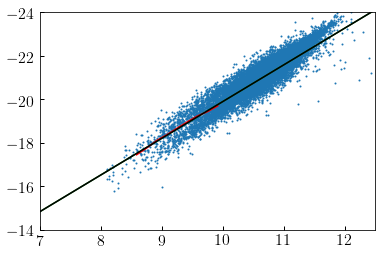

In [4]:
from scipy.stats import binned_statistic
logsm_bins = np.linspace(8.5, 10, 10)
logsm_mids = 0.5*(logsm_bins[:-1] + logsm_bins[1:])
result, __, __ = binned_statistic(sdss['sm'], sdss['rmag'], bins=logsm_bins, statistic='median')
p1, p0 = np.polyfit(logsm_mids, result, deg=1)
logsm_abscissa = np.linspace(5, 15, 100)
logsm_ordinates = p0 + p1*logsm_abscissa


fig, ax = plt.subplots(1, 1)

xlim = ax.set_xlim(7, 12.5)
ylim = ax.set_ylim(-14, -24)

nskip = 10
__=ax.scatter(sdss['sm'][::nskip], sdss['rmag'][::nskip], s=1)

__=ax.plot(logsm_abscissa, logsm_ordinates, color='green')
__=ax.plot(logsm_mids, result, color='red')


from rescale_dc2.generate_fake_sdss_data import polyfit_median_quantity_vs_mstar as estimate_magr

log10_mstar = np.linspace(9, 12, 1000)
data_log10_mstar = sdss['sm']
data_AbsMagr = sdss['rmag']
logsm_fitting_range = (8.5, 10)

x = np.linspace(7, 12.5, 1000)
model_magr = estimate_magr(x, data_log10_mstar, data_AbsMagr, logsm_fitting_range)
__=ax.plot(x, model_magr, color='k')


## Develop Monte Carlo realization of $M_{\rm r}$ based on the $M_{\ast}-M_{\rm r}$ relation

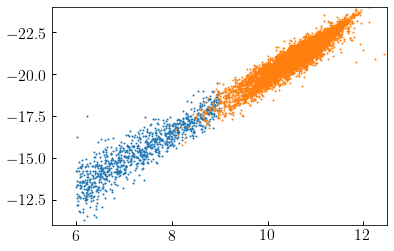

In [5]:
from rescale_dc2.generate_fake_sdss_data import polyfit_median_quantity_vs_mstar as estimate_median_magr

log10_mstar = np.linspace(9, 12, 1000)
data_log10_mstar = sdss['sm']
data_AbsMagr = sdss['rmag']
logsm_fitting_range = (8.5, 10)

logsm_table = np.linspace(7, 12.5, 1000)
model_magr_table = estimate_magr(logsm_table, data_log10_mstar, data_AbsMagr, logsm_fitting_range)

npts_mock_sample = int(1e3)
mstar_mock_sample = np.random.uniform(6, 9, npts_mock_sample)
median_magr = estimate_median_magr(mstar_mock_sample, data_log10_mstar, data_AbsMagr, logsm_fitting_range)
magr_scatter_array = np.interp(mstar_mock_sample, [6, 8], [1, 0.5])

from rescale_dc2.generate_fake_sdss_data import monte_carlo_magr_mock_sample

magr_mock_sample = monte_carlo_magr_mock_sample(
    mstar_mock_sample, data_log10_mstar, data_AbsMagr, 
    logsm_fitting_range, magr_scatter=magr_scatter_array)

fig, ax = plt.subplots(1, 1)

xlim = ax.set_xlim(5.5, 12.5)
ylim = ax.set_ylim(-11, -24)

nskip = 20
__=ax.scatter(mstar_mock_sample, magr_mock_sample, s=1)
__=ax.scatter(sdss['sm'][::nskip], sdss['rmag'][::nskip], s=1)


## Develop an approximation of ${\rm ri-gr}$ space as a multivariate Gaussian

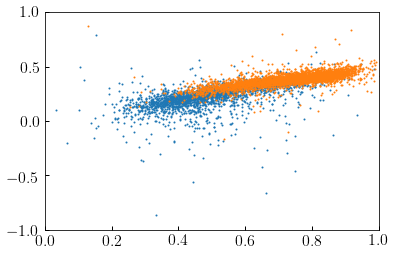

In [6]:
fig, ax = plt.subplots(1, 1)

xlim = ax.set_xlim(0, 1)
ylim = ax.set_ylim(-1, 1)

sdss_mask = (sdss['sm'] < 10) & (sdss['z'] < 0.02)
sdss_mask2 = (sdss['sm'] > 10) & (sdss['sm'] < 11) & (sdss['z'] < 0.05) & (np.random.rand(len(sdss)) < 0.2)
nskip = 10
__=ax.scatter(sdss['sdss_petrosian_gr'][sdss_mask], sdss['sdss_petrosian_ri'][sdss_mask], s=1)
__=ax.scatter(sdss['sdss_petrosian_gr'][sdss_mask2], sdss['sdss_petrosian_ri'][sdss_mask2], s=1)



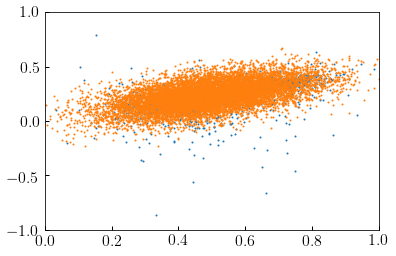

In [7]:
sdss_mask = (sdss['sm'] < 10) & (sdss['z'] < 0.02)

X = np.vstack((sdss['sdss_petrosian_gr'][sdss_mask], sdss['sdss_petrosian_ri'][sdss_mask]))
cov = np.cov(X)

num_sample = int(1e4)

from scipy.stats import binned_statistic

data_log10_mstar = sdss['sm'][sdss_mask]
data_gr = sdss['sdss_petrosian_gr'][sdss_mask]
log10_mstar = mstar_mock_sample
logsm_fitting_range = (8.5, 10)
median_gr = estimate_median_magr(log10_mstar, data_log10_mstar, data_gr,
            logsm_fitting_range)
data_ri = sdss['sdss_petrosian_ri'][sdss_mask]
median_ri = estimate_median_magr(log10_mstar, data_log10_mstar, data_ri,
            logsm_fitting_range)

median_gr = np.median(data_gr)
median_ri = np.median(data_ri)

mean_array = np.repeat(np.array((median_gr, median_ri)), num_sample).reshape((2, num_sample))

Z = np.random.multivariate_normal(mean=(median_gr, median_ri), cov=cov, size=num_sample)
mock_gr, mock_ri = Z[:, 0], Z[:, 1]

fig, ax = plt.subplots(1, 1)

xlim = ax.set_xlim(0, 1)
ylim = ax.set_ylim(-1, 1)

sdss_mask = (sdss['sm'] < 10) & (sdss['z'] < 0.02)
nskip = 10
__=ax.scatter(sdss['sdss_petrosian_gr'][sdss_mask], sdss['sdss_petrosian_ri'][sdss_mask], s=1)

__=ax.scatter(mock_gr, mock_ri, s=1)


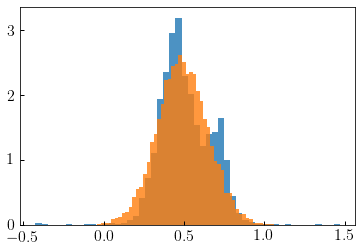

In [8]:
fig, ax = plt.subplots(1, 1)

__=ax.hist(sdss['sdss_petrosian_gr'][sdss_mask], bins=50, normed=True, alpha=0.8)
__=ax.hist(mock_gr, bins=50, normed=True, alpha=0.8)

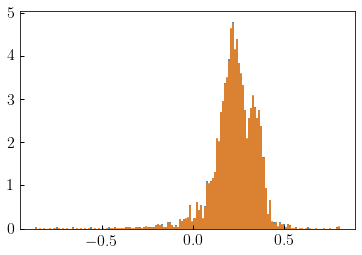

In [9]:
fig, ax = plt.subplots(1, 1)

from halotools.empirical_models import conditional_abunmatch

rescaled_mock_ri = conditional_abunmatch(mock_ri, sdss['sdss_petrosian_ri'][sdss_mask])
rescaled_mock_gr = conditional_abunmatch(mock_gr, sdss['sdss_petrosian_gr'][sdss_mask])

__=ax.hist(sdss['sdss_petrosian_ri'][sdss_mask], bins=150, normed=True, alpha=0.8)
__=ax.hist(rescaled_mock_ri, bins=150, normed=True, alpha=0.8)

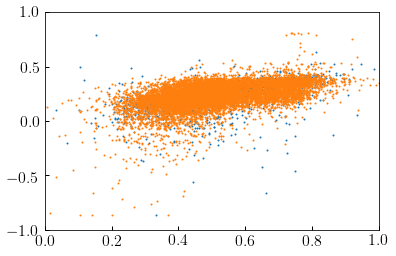

In [10]:
fig, ax = plt.subplots(1, 1)

xlim = ax.set_xlim(0, 1)
ylim = ax.set_ylim(-1, 1)

sdss_mask = (sdss['sm'] < 10) & (sdss['z'] < 0.02)
nskip = 10
__=ax.scatter(sdss['sdss_petrosian_gr'][sdss_mask], sdss['sdss_petrosian_ri'][sdss_mask], s=1)

__=ax.scatter(rescaled_mock_gr, rescaled_mock_ri, s=1)
